In [2]:
import csv
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from statsmodels.tsa.tsatools import lagmat
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as TSG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
import tensorflow as tf

ts_dir = '/Users/danielfriedman/Desktop/CS109b/final_project/timeseries/'
ts_dir = '/Users/joannafriedman/Desktop/CS109b/final_project/timeseries/'
# ts_dir = '/jupyteruser/31170133/timeseries'
os.chdir(ts_dir)

In [3]:
# # Only run if us_mobility.csv hasn't been created

# global_mob = pd.read_csv('Global_Mobility_Report.csv', dtype = {'sub_region_2':object})
# mob = global_mob[global_mob['country_region'] == 'United States'].drop(columns = ['country_region_code','country_region'])
# mapper1 = {'sub_region_1':'state', 'sub_region_2':'county'}
# mapper2 = pd.Series(index = mob.columns[3:], data = ['retail','grocery','parks','transit','work','residential'])
# mob.rename(columns = mapper1, inplace = True)
# mob.rename(columns = mapper2, inplace = True)
# mob.loc[mob['state'] == 'District of Columbia', 'county'] = 'DC'
# mob = mob[(~pd.isnull(mob['state'])) & (~pd.isnull(mob['county']))].reset_index(drop = True)
# mob['county'] = mob.county.str.replace(' County', '')
# mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
# mob.to_csv('us_mobility.csv', index = False)

In [20]:
mob = pd.read_csv('us_mobility.csv')
mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
mob.head()
mob[(mob['state'] == 'New York') & (mob['county'] == 'New York')].head()

,state,county,date,retail,grocery,parks,transit,work,residential
89341,New York,New York,2020-02-15,2.0,-5.0,0.0,-1.0,0.0,0.0
89342,New York,New York,2020-02-16,6.0,-2.0,4.0,1.0,-2.0,0.0
89343,New York,New York,2020-02-17,-5.0,-12.0,13.0,-25.0,-51.0,10.0
89344,New York,New York,2020-02-18,0.0,-2.0,5.0,-5.0,-6.0,2.0
89345,New York,New York,2020-02-19,2.0,-1.0,15.0,-1.0,-4.0,1.0


In [5]:
nyt = pd.read_csv(f'nyt/us-counties.csv')
nyt['date'] = nyt['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
nyt['county'] = nyt.county.str.replace('City', '').str.strip()
nyt.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [6]:
### TODO: match by county better
mobcounties = mob.county.unique()
nytcounties = nyt.county.unique()
print(len([c for c in mobcounties if c not in nytcounties]))
print(len([c for c in nytcounties if c not in mobcounties]))

198
148


In [7]:
mob = mob.merge(nyt, how = 'left', on = ['state','county','date'])
mob['cases'].fillna(0, inplace = True) # if it's nan, that means they hadn't had cases
mob['deaths'].fillna(0, inplace = True) # if it's nan, that means they hadn't had deaths

#### Get metric of mobility

In [9]:
# Standardize
fullcats = ['grocery','parks','residential','retail','transit','work']
cats = ['grocery','residential','retail','transit','work'] # note: only use these categories for building PCs
ss = SS().fit(mob[fullcats])
mob_standard = pd.DataFrame(ss.transform(mob[fullcats]), columns = fullcats)
mob_standard.fillna(0, inplace = True)

# PCA
N_COMPONENTS = 3
pca = PCA(n_components = N_COMPONENTS).fit(mob_standard)
pcs = ['pc'+str(i) for i in range(N_COMPONENTS)]
mob[pcs] = pd.DataFrame(pca.transform(mob_standard))
mob.head()

,state,county,date,retail,grocery,parks,transit,work,residential,fips,cases,deaths,pc0,pc1,pc2
0,Alabama,Autauga,2020-02-15,5.0,7.0,NaN,NaN,-4.0,NaN,NaN,0.0,0.0,0.808947,-0.023098,-0.356951
1,Alabama,Autauga,2020-02-16,0.0,1.0,-23.0,NaN,-4.0,NaN,NaN,0.0,0.0,0.474919,-0.402266,-0.703660
2,Alabama,Autauga,2020-02-17,8.0,0.0,NaN,NaN,-27.0,5.0,NaN,0.0,0.0,0.071361,-0.073216,-0.038536
3,Alabama,Autauga,2020-02-18,-2.0,0.0,NaN,NaN,2.0,0.0,NaN,0.0,0.0,0.927697,-0.685857,-0.072876
4,Alabama,Autauga,2020-02-19,-2.0,0.0,NaN,NaN,2.0,0.0,NaN,0.0,0.0,0.927697,-0.685857,-0.072876


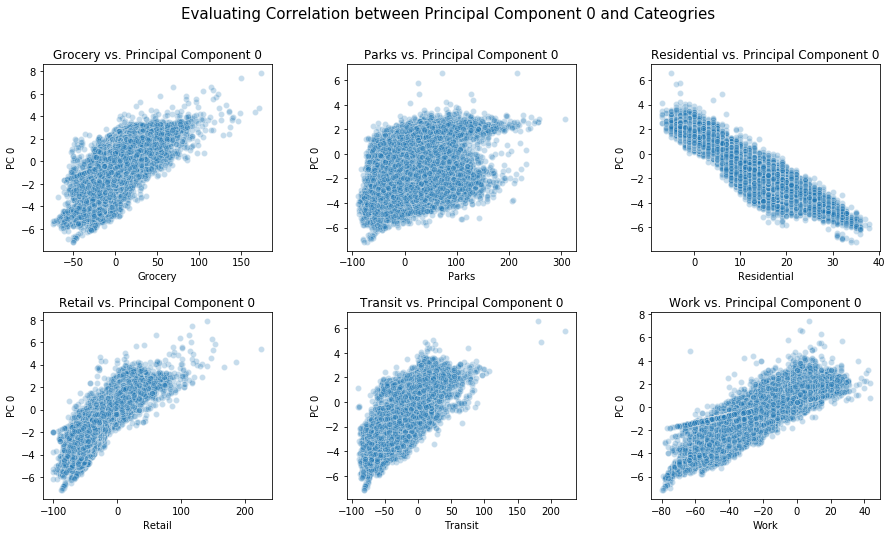

In [10]:
### TODO: double check this 
component = 0
fig, axes = plt.subplots(2, 3, figsize = (15,8))
for i, ax in enumerate(axes.ravel()):
    sns.scatterplot(mob[fullcats[i]], mob[f'pc{component}'], ax = ax, alpha = 0.25);
    ax.set(xlabel = fullcats[i].capitalize(),
           ylabel = 'PC '+str(component), 
           title = fullcats[i].capitalize() + ' vs. Principal Component ' + str(component))
fig.subplots_adjust(hspace = .33, wspace = .33);
fig.suptitle(f'Evaluating Correlation between Principal Component {component} and Cateogries', fontsize = 15);

#### Baseline Model

In [11]:
predictors = pcs
target = 'cases'
keepers = list(predictors) + [target]
mob_nonull = mob[~pd.isnull(mob['cases'])].reset_index(drop = 1) # TODO: 
mob_nonull.head()

,state,county,date,retail,grocery,parks,transit,work,residential,fips,cases,deaths,pc0,pc1,pc2
0,Alabama,Autauga,2020-02-15,5.0,7.0,NaN,NaN,-4.0,NaN,NaN,0.0,0.0,0.808947,-0.023098,-0.356951
1,Alabama,Autauga,2020-02-16,0.0,1.0,-23.0,NaN,-4.0,NaN,NaN,0.0,0.0,0.474919,-0.402266,-0.703660
2,Alabama,Autauga,2020-02-17,8.0,0.0,NaN,NaN,-27.0,5.0,NaN,0.0,0.0,0.071361,-0.073216,-0.038536
3,Alabama,Autauga,2020-02-18,-2.0,0.0,NaN,NaN,2.0,0.0,NaN,0.0,0.0,0.927697,-0.685857,-0.072876
4,Alabama,Autauga,2020-02-19,-2.0,0.0,NaN,NaN,2.0,0.0,NaN,0.0,0.0,0.927697,-0.685857,-0.072876


In [12]:
# longest = 57
longest = mob_nonull.groupby(['state','county']).apply(lambda x: len(x)).value_counts().idxmax()
longest_only = mob_nonull.groupby(['state','county']).filter(lambda x: len(x) == longest) # keep only the ones with length 57 TODO change
grouped = longest_only.groupby(['state','county'])
state_county_groups = np.array(list(grouped.groups.keys()))



In [13]:
nahead = 3
period = longest - nahead

def getlags(y, nahead):
    lags = lagmat(y, maxlag = nahead, trim = 'both', original = 'in')[:,nahead-1::-1]
    return lags

X = np.stack([county[1][keepers].values for county in grouped])
y = np.apply_along_axis(lambda y: getlags(y, nahead), 1, X[:,:,-1])
X = X[:,:-nahead,:]
print(X[:,:-nahead,:].shape)
print(y.shape)

(2197, 51, 4)
(2197, 54, 3)


In [14]:
nunits = 500
droprate = 0.1

inputs = Input(shape = (period, len(keepers)), name = 'inputs')
lstm1 = LSTM(units = nunits, return_sequences = True, name = 'lstm1', activation = 'tanh')(inputs)
drop1 = Dropout(rate = droprate, name = 'drop1')(lstm1)
lstm2 = LSTM(units = nunits, return_sequences = True, name = 'lstm2', activation = 'tanh')(drop1)
outputs = TimeDistributed(Dense(nahead, activation = 'linear', name = 'outputs'))(lstm2)
mod = Model(inputs, outputs, name = 'mod')
mod.compile('adam', loss = 'mean_squared_error')
mod.summary()

Model: "mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 54, 4)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 54, 500)           1010000   
_________________________________________________________________
drop1 (Dropout)              (None, 54, 500)           0         
_________________________________________________________________
lstm2 (LSTM)                 (None, 54, 500)           2002000   
_________________________________________________________________
time_distributed (TimeDistri (None, 54, 3)             1503      
Total params: 3,013,503
Trainable params: 3,013,503
Non-trainable params: 0
_________________________________________________________________


In [15]:
# epochs = 250
# batch_size = 32
# validation_split = 0.15
# verbose = 2
# history = mod.fit(X, y, batch_size = batch_size, epochs = epochs, validation_split = validation_split, verbose = verbose)




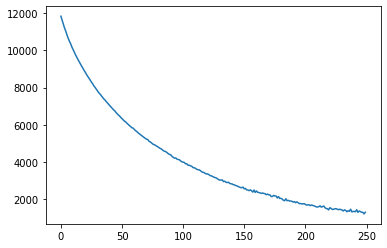

In [23]:
# sns.lineplot(np.arange(len(history.history['val_loss'])), history.history['val_loss']);

In [36]:
# mod.save('models/noactivation.h5')
# mod = load_model('models/noactivation.h5')

In [16]:
# mod.save('models/baseline.h5')  # creates a HDF5 file 'my_model.h5'
mod = load_model('models/baseline.h5')
yhat = mod.predict(X)

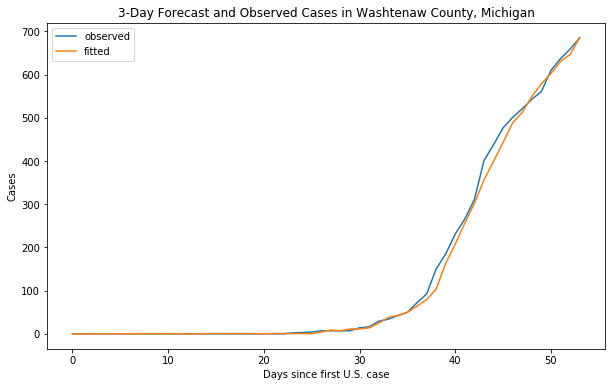

In [35]:
# county = biggest = np.argmax(y[:,:,0].max(1))
statename = 'Michigan'
countyname = 'Washtenaw'
county = np.argwhere((state_county_groups == [statename, countyname]).sum(1) == 2)[0][0]
# statename, countyname = state_county_groups[county]
d = 2
ytrue = y[county, :, d]
ypred = yhat[county, :, d]
days_predicted = len(yhat[0])
fig, ax = plt.subplots(figsize = (10,6))
sns.lineplot(np.arange(days_predicted), ytrue, label = 'observed')
sns.lineplot(np.arange(days_predicted), ypred, label = 'fitted')
ax.set(xlabel = 'Days since first U.S. case', ylabel = 'Cases', title = f'{d + 1}-Day Forecast and Observed Cases in {countyname} County, {statename}');


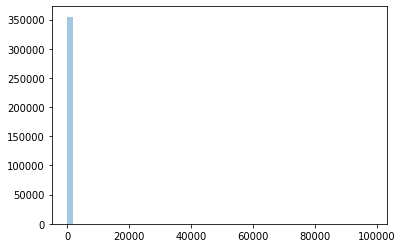

In [31]:
sns.distplot(y.flatten(), kde = False)

Group steps 

- Everyone read notebook
- Everyone change a thing 
- other data ideas? 
    - County level

Ideas 

- Change to per capita
- Or look at daily change 
- Read comments
- Add other countries 
- do at state level
- Demographics 
- 
- Track successes/failures of each model 